## Lab: Cart Pole Demo 2 using OpenAI gym
## Policy Gradient

### University of Virginia
### Reinforcement Learning
#### Last updated: March 4, 2024

Jack Burke
jpb2uj

---


#### Instructions:  

Carefully read the notes below and run the provided code. Answer each question clearly and show all results.

#### TOTAL POINTS: 12

---

### First a Refresh

Let's briefly review the content from Demo 1: Basics and Simple Policy

We revisit the CartPole problem.

We will work with the fork [gymnasium](https://gymnasium.farama.org/) which maintains OpenAI gym.  

The *simple policy* didn't perform very well: the average reward was about 42.

We want to see if we can do better using a Policy Gradient algorithm.

### Setup and First Steps

In [1]:
! pip install gymnasium

In [2]:
! pip install renderlab

In [3]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import renderlab as rl

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



Load the environment

In [ ]:
env = gym.make("CartPole-v1", render_mode = "rgb_array")
state = env.reset(seed=314)

Given the state, we take an action. The next state comes from the environment, which is encoded in `gym`.

Components:   
[0]: cart horizontal position (0.0 = center)  
[1]: velocity (positive means right)  
[2]: angle of the pole (0.0 = vertical)  
[3]: pole's angular velocity (positive means clockwise)

In [ ]:
state

(array([0.04225422, 0.02126478, 0.02520455, 0.00700802], dtype=float32), {})

In [ ]:
# state space number of components
env.observation_space.shape[0]

4

The action space consists of two options:

[0]: move cart left   
[1]: move cart right

In [ ]:
env.action_space

Discrete(2)

Let's take an action, draw a sample and look at the results.

In [ ]:
# move right
action = 1

# take a step and get next state, reward from environment
state, reward, terminated, truncated, info = env.step(action)
done = terminated or truncated

print('state', state)
print('reward', reward)
print('done', done)
print('info', info)

state [ 0.04267951  0.21601637  0.02534471 -0.27761722]
reward 1.0
done False
info {}


**Reward and Episode**  

For each time step that the cart keeps the pole balanced, it earns reward 1.

If the pole tilts too much or if the cart moves off screen, `reward=0` and `done=True` (the episode will end).

When the episode ends, a new episode may begin. The process learns cumulatively from each episode.

**Simple policy**:  

When the pole leans left (negative angle), move left. When the pole leans right (positive angle), move right.

Run many episodes and visualize their reward distribution.

In [ ]:
def simple_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

num_episodes = 1000
num_steps = 1000
rewards = []

for episode in range(num_episodes):
    ep_reward = 0
    state = env.reset()[0]
    for step in range(num_steps):
        #print(state)
        action = simple_policy(state)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        ep_reward += reward
        if done:
            break

    rewards.append(ep_reward)

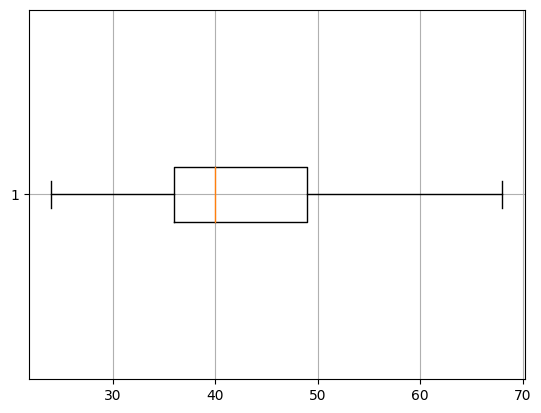

In [ ]:
plt.boxplot(rewards, vert=False)
plt.grid()
plt.show()

In [ ]:
print('mean reward:', np.mean(rewards))

mean reward: 42.213


### Neural Network Policy

Now we try a more sophisticated policy: let's use a neural network.

The network will take **state as input**. The output node will contain the probability of the actions.

Since there are two actions (left, right), we require one output node.  
Node will output probability of right (so prob of left is implied).

For simplicity, we will use one hidden layer.

Number of nodes in hidden layer is a hyperparameter.

---


#### 1) **Define a neural network model for the policy.**

**(POINTS: 1)**  
It should have appropriate dimensions for the input and output layer. Print a summary of the model that shows the output shape for each layer.

In [13]:
import torch
import torch.nn as nn

class PolicyNN(nn.Module):
  def __init__(self, hidden_size = 32):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(4, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid()
    )
  def forward(self, x):
    return self.net(x)

In [14]:
model = PolicyNN(hidden_size=32)

print(model)

PolicyNN(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


#### 2) Is **REINFORCE** a Monte Carlo method? Explain your answer.

**(POINTS: 1)**

Yes, REINFORCE is a Monte Carlo method. It updates the policy only after an episode is completed, using the returns from that episode. Full-episode returns are calculated using Monte Carlo sampling, then the policy is updated when the episode ends.



#### 3) **Training and Evaluating the Policy Model.**

Define functions to train and evaluate the model. Your work should include the steps below among others. Note that subtasks are numbered [1], [2], etc. and are worth one point each.

- **(POINTS: 2)** Write a function `play_single_step` to evolve the system one step. It should also compute the gradient of the loss function. Test that it works properly and print the next state.  

- **(POINTS: 2)** Write a function that runs multiple episodes, calling the `play_single_step` function. It should also compute and store the reward and gradient for each time step of each episode. Test that it works properly and print the rewards from running two episodes each with five time steps.
- **(POINTS: 3)** Define and run a training loop using the REINFORCE algorithm that [1] runs multiple episodes, [2] computes discounted rewards, and [3] updates the parameters with gradient ascent. Run a sufficient number of episodes and time steps to see an average reward of at least 75 in the `evaluate` step that follows. Show evidence that the training loop is working, such as printing the total discounted rewards per episode.
- **(POINTS: 3)** Now that the model is trained, you can use it as the policy and evaluate performance. Write code that [1] applies the model as the policy, [2] runs 1000 episodes and [3] computes the minimum reward, average reward, and maximum reward across the episodes. Discuss how the average reward from REINFORCE compares to the average reward from the simple policy from Cart Pole lab 1.

---

In [15]:
# play_single_step
import torch.optim as optim
from torch.distributions import Bernoulli

def play_single_step(env, model, state):
    state_t = torch.tensor(state, dtype=torch.float32)

    # Forward pass
    prob_right = model(state_t)
    m = Bernoulli(prob_right)
    action = m.sample()

    # Convert decimal probability to int action
    action_int = int(action.item())

    # Step the environment
    next_state, reward, terminated, truncated, info = env.step(action_int)
    done = terminated or truncated

    # Compute log-prob gradient
    log_prob = m.log_prob(action)
    log_prob_grad = log_prob

    return next_state, reward, done, log_prob_grad

env = gym.make("CartPole-v1")
state, _ = env.reset()

next_state, reward, done, grad = play_single_step(env, PolicyNN(), state)
print(next_state)


[-0.02326423  0.15534712 -0.00881387 -0.25060967]


In [23]:
# play_multiple_steps

def run_episodes(env, model, num_episodes, max_steps=500):
    all_episode_rewards = []
    all_episode_log_probs = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        rewards = []
        log_probs = []

        for t in range(max_steps):
            next_state, reward, done, log_prob_grad = play_single_step(env, model, state)

            rewards.append(reward)
            log_probs.append(log_prob_grad)

            state = next_state
            if done:
                break

        all_episode_rewards.append(rewards)
        all_episode_log_probs.append(log_probs)

    return all_episode_rewards, all_episode_log_probs

rewards, logps = run_episodes(env, PolicyNN(), num_episodes=2, max_steps=5)
print("Episode rewards:", rewards)

Episode rewards: [[1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0]]


In [33]:
# training loop

def compute_discounted_rewards(rewards, gamma=0.99):
    discounted = np.zeros_like(rewards, dtype=np.float32)
    running = 0.0
    for t in reversed(range(len(rewards))):
        running = rewards[t] + gamma * running
        discounted[t] = running
    return discounted

def train_reinforce(env, model, optimizer,
                    num_episodes=500, max_steps=500, gamma=0.99, stop_early=False):

    for episode in range(num_episodes):
        # Collect experience
        ep_rewards, ep_log_probs = run_episodes(
            env, model, num_episodes=1, max_steps=max_steps
        )
        rewards = ep_rewards[0]
        log_probs = ep_log_probs[0]

        # Compute discounted rewards
        discounted = compute_discounted_rewards(rewards, gamma)

        discounted_t = torch.tensor(discounted, dtype=torch.float32)

        # Policy gradient loss
        loss = 0
        for log_prob, Gt in zip(log_probs, discounted_t):
            loss += -log_prob * Gt

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Episode {episode:4d} | "
              f"Total Reward = {sum(rewards)}")

        # Stop early once performance is good
        if stop_early and np.sum(rewards) >= 200:
            print("Stopping early — reached target performance.")
            break

env = gym.make("CartPole-v1")
model = PolicyNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_reinforce(env, model, optimizer, num_episodes = 200, stop_early=True)



Episode    0 | Total Reward = 16.0
Episode    1 | Total Reward = 26.0
Episode    2 | Total Reward = 23.0
Episode    3 | Total Reward = 14.0
Episode    4 | Total Reward = 66.0
Episode    5 | Total Reward = 24.0
Episode    6 | Total Reward = 52.0
Episode    7 | Total Reward = 12.0
Episode    8 | Total Reward = 40.0
Episode    9 | Total Reward = 24.0
Episode   10 | Total Reward = 12.0
Episode   11 | Total Reward = 24.0
Episode   12 | Total Reward = 33.0
Episode   13 | Total Reward = 27.0
Episode   14 | Total Reward = 32.0
Episode   15 | Total Reward = 22.0
Episode   16 | Total Reward = 16.0
Episode   17 | Total Reward = 23.0
Episode   18 | Total Reward = 37.0
Episode   19 | Total Reward = 36.0
Episode   20 | Total Reward = 25.0
Episode   21 | Total Reward = 24.0
Episode   22 | Total Reward = 27.0
Episode   23 | Total Reward = 46.0
Episode   24 | Total Reward = 53.0
Episode   25 | Total Reward = 101.0
Episode   26 | Total Reward = 30.0
Episode   27 | Total Reward = 22.0
Episode   28 | Tota

(POINTS: 3) Now that the model is trained, you can use it as the policy and evaluate performance. Write code that [1] applies the model as the policy, [2] runs 1000 episodes and [3] computes the minimum reward, average reward, and maximum reward across the episodes. Discuss how the average reward from REINFORCE compares to the average reward from the simple policy from Cart Pole lab 1.

In [34]:
# evaluate policy performance
def evaluate_policy(env, model, num_episodes=1000, max_steps=500):
    rewards = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        total = 0

        for t in range(max_steps):
            state_t = torch.tensor(state, dtype=torch.float32)
            prob = model(state_t).item()
            action = 1 if np.random.rand() < prob else 0

            state, reward, terminated, truncated, _ = env.step(action)
            total += reward
            if terminated or truncated:
                break

        rewards.append(total)

    return min(rewards), np.mean(rewards), max(rewards)

min_r, avg_r, max_r = evaluate_policy(env, model)

print("Evaluation Results:")
print(f"  Min reward: {min_r}")
print(f"  Avg reward: {avg_r:.2f}")
print(f"  Max reward: {max_r}")


Evaluation Results:
  Min reward: 26.0
  Avg reward: 94.54
  Max reward: 275.0


After training the model for just 133 episodes, until it reached an episode with a total reward greater than 200, its performance in the evaluation step gave an average reward of 94.54. This is significantly higher than the simple policy's average reward of 42, and even higher than the simple policy's maximum reward.